# Introduction to Python for Earth Scientists

These notebooks have been developed by Calum Chamberlain, Finnigan Illsley-Kemp and John Townend at [Victoria University of Wellington---Te Herenga Waka](https://www.wgtn.ac.nz) for use by students entering the postgraduate programme in Earth Science.

We presume very little background in command-line or code-based computing, and have compiled this material with an emphasis on general tasks that a grad student might encounter on a daily basis. 

| Notebook | Contents | Data |
| --- | --- | --- |
| [1A](ESCI451_Module_1A.ipynb) | Introduction to programming, Python, and Jupyter notebooks | - |
| [1B](ESCI451_Module_1B.ipynb) | Basic data types and variables, getting data, and plotting with Matplotlib | Geodetic positions |
| **[2A](ESCI451_Module_2A.ipynb)** | **More complex plotting, introduction to Numpy** | **Geodetic positions; DFDP-2B temperatures** |
| [2B](ESCI451_Module_2B.ipynb) | Using Pandas to load, peruse and plot data | Earthquake catalogue  |
| [3A](ESCI451_Module_3A.ipynb) | Working with Pandas dataframes | Geochemical data set; earthquake catalogue |
| [3B](ESCI451_Module_3B.ipynb) | Simple time series analysis using Pandas | TBD |
| [4A](ESCI451_Module_4A.ipynb) | Making maps with Cartopy | Earthquake catalogue |
| [4B](ESCI451_Module_4B.ipynb) | Working with gridded data | DEMs and Ashfall data |

The content may change in response to students' questions or current events. Each of the four modules has been designed to take about three hours, with a short break between each of the two parts.


## Some more plotting

In the last notebook we looked at plotting a single data set and labelling the diagram in a helpful way. Next we'll look at how we can combine different data sets (here the three components of motion measured at PYGR) in a single set of axes.

Remember, we first have to import any packages (notably Matplotlib in this case) that we are going to use. We also need to respecify the function we used previously to get the GNSS data from [GeoNet](https://www.geonet.org.nz).

In [1]:
import matplotlib.pyplot as plt
import requests  # This helps with web-requests
import datetime  # Python's representation of dates and times.

# The following block of code defines a function that we can use
# as often as we like to get GNSS data for a particular station
def get_gnss_for_station(
    station: str, 
    fits_url: str = "http://fits.geonet.org.nz/observation",) -> dict:
    """
    Get GNSS data from GeoNet for the station
    
    Parameters
    ----------
    station
        The name of the station you want to get data for
    fits_url
        URL of the FITS data service you want to query.
        
    Returns
    -------
    Dictionary with keys:
        time 
            list of timestamps of observations
        north
            list of offsets in mm in the north direction
        east
            list of offsets in mm in the east direction
        up          
            list of vertical offsets in mm
        north_error
            list of errors in mm for north
        east_error
            list of errors in mm for east
        up_error
            list of erros in mm for up
    
    """
    # Initialise an empty dictionary that we will append to
    out = dict(time=[],
               north=[],
               east=[],
               up=[],
               north_error=[],
               east_error=[],
               up_error=[])
    for channel in {"north", "east", "up"}:
        parameters = {"typeID": channel[0], "siteID": station}
        response = requests.get(fits_url, params=parameters)
        assert response.status_code == 200, "Bad request"
        payload = response.content.decode("utf-8").split("\n")
        # payload is a csv with header
        # This is a list-comprehension, a type of fast, one-line for loop
        payload = [p.split(',') for p in payload]
        # Check that this is what we expect
        assert payload[0][0] == 'date-time', "Unkown format"
        assert len(payload[0]) == 3, "Unknown format"
        times, displacements, errors = zip(*[
            (datetime.datetime.strptime(p[0], '%Y-%m-%dT%H:%M:%S.%fZ'),
             float(p[1]), float(p[2])) for p in payload[1:-1]])
        if len(out["time"]) == 0:
            out.update({"time": times})
        else:
            assert out["time"] == times, "Different time sampling for different components."
        out.update({channel: displacements, f"{channel}_error": errors})
    return out

Next we'll do something similar to the last exercise but use a `loop` to avoid writing the same code three times.

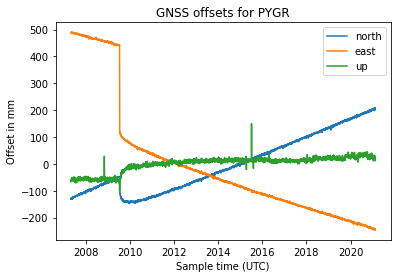

In [2]:
pygr_data = get_gnss_for_station(station="PYGR")
fig, ax = plt.subplots()
# This is the loop
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component], 
            label=component)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

The step shows up on all components! Who would have thought it...?

## 3.7: Customizing plots

Matplotlib automatically plots each line in a different colour, which is great! But maybe you don't like the
default colours? We can specify colours, and loop through them as well if we want:

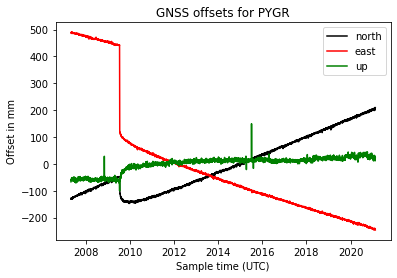

In [3]:
fig, ax = plt.subplots()
# Using the `zip` command we can iterate through pairs of lists.
for component, colour in zip(["north", "east", "up"], ["black", "red", "green"]):
    # We add the color keyword argumet to set the colour of the line.
    ax.plot(pygr_data["time"], pygr_data[component], 
            label=component, color=colour)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

You will note that Matplotlib uses American (wrong) spelling.  You get used to it.

You can control all sorts of other style aspects of Matplotlib. One of the simplest ways is to change the `stylesheet` that matplotlib is using.  There are quite a few of them, with  [examples here](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html). Try experimenting with different options to see which ones you prefer.

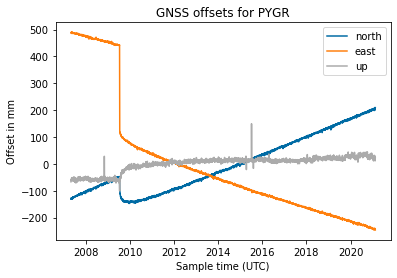

In [4]:
plt.style.use("tableau-colorblind10")
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component], 
            label=component)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

Nice.

Something you might find yourself wanting to do now and again is to focus on only part of your data. One way of doing that is to just change the limits of the axes:

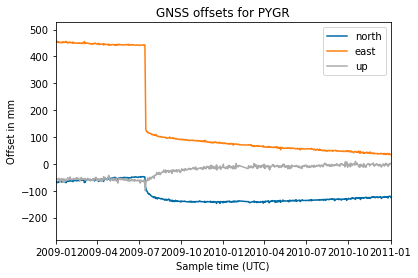

In [5]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component], 
            label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

We will look at some other methods in the next notebook when we encounter the infamous `Pandas` dataframe...

So far we have plotted data as a continuous line.  For continuous data like this, this is fine, but what if we want
to look at discrete samples?

In matplotlib you can make a scatter plot by specifying a marker (in this case we are using a **o** symbol, which gives a circle),
and setting the `linestyle` to `"None"` (or perhaps `dotted` or even `dashed`, if you want to retain a bit of a line). You can achieve the same result using `ax.scatter(x, y, marker="o")`,
but we will use the `.plot` method here because we need the arguments later...

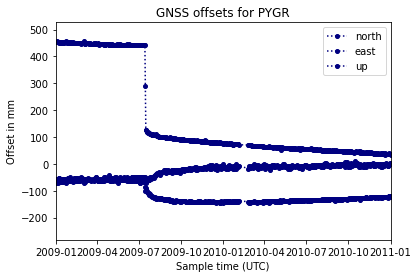

In [6]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.plot(pygr_data["time"], pygr_data[component], 
            marker="o", markersize=4,linestyle="dotted",color='navy',
            label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

We can immediately see that there is a gap in the data in early 2010 that wasn't obvious in our previous plots, which is helpful reminder that "continuous" data are not always as continuous as they seem.

## 3.9: Plotting uncertainties

The data that we are plotting are daily solutions of position relative to some reference point.  These daily solutions are
essentially averages (with quite a lot of extra noise reduction and weighting) of samples taken at much higher frequencies.
These positions are provided with error estimations: you should always plot your uncertainty to ensure you are not
over-interpreting features.  Lets plot some error bars on these points.

Remember those `marker` and `linestyle` arguments? We need them here as well.

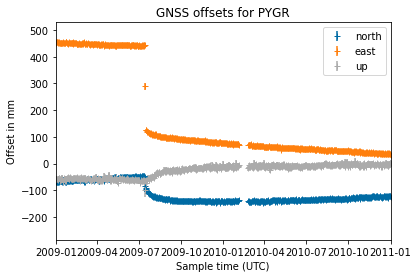

In [7]:
fig, ax = plt.subplots()
for component in ["north", "east", "up"]:
    ax.errorbar(pygr_data["time"], pygr_data[component], 
                yerr=pygr_data[f"{component}_error"],
                marker="+", linestyle="None",
                label=component)
ax.set_xlim(datetime.datetime(2009, 1, 1), datetime.datetime(2011, 1, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

They are plotted, but hard to see, lets plot just the vertical (up) component between 2009/06 and 2009/08:

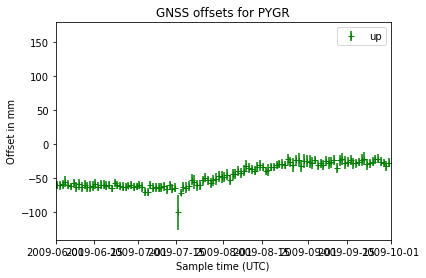

In [8]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"], 
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

This has kept the y-limits the same as for the whole dataset, meaning that we still can't see much! Let's adjust those
y limits in the same way that we adjusted the x-limits.

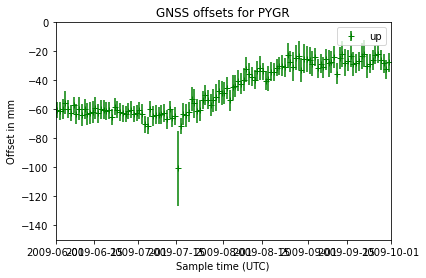

In [9]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"], 
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_ylim(-150, 0)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

Great, we can see that there is a large error for a particular point there.  For those who haven't guessed it yet, this is the day of the [Dusky Sound earthquake](https://www.geonet.org.nz/earthquake/story/3124785). The errors are largest here because the displacement is a) large and b) not instantaneous. There are components of co-seismic and post-seismic slip in this one data-point that effectively smear the motion. 

These daily GPS solutions are not *true* measurements, rather a model of the displacements based on data. To use these data to model slip on faults, or other phenomena models are often built on top of these daily solutions (models themselves).  If you don't understand the uncertainty in your data (whether those data are raw data, or modeled data) you won't understand the uncertainty in your final result...

One last thing for now, our tick labels on the x-axis are overlapping, obscuring them from view. Lets sort that out as well:

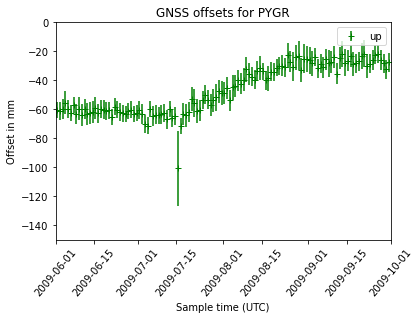

In [10]:
fig, ax = plt.subplots()
ax.errorbar(pygr_data["time"], pygr_data["up"], 
            yerr=pygr_data["up_error"],
            marker="+", linestyle="None",
            label=component, color="green")
ax.set_xlim(datetime.datetime(2009, 6, 1), datetime.datetime(2009, 10, 1))
ax.set_ylim(-150, 0)
# Set the x-labels to be rotated so that they don't overlap.
plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
ax.set_xlabel("Sample time (UTC)")
ax.set_ylabel("Offset in mm")
ax.set_title("GNSS offsets for PYGR")
ax.legend()
plt.show()

**Exercise:** Make a plot of the GNSS time-series for a station of your choosing. 

Look on the [GeoNet station search](https://www.geonet.org.nz/data/network/sensor/search) and tick the
GNSS/GPS box to show the GNSS stations.  Try and find one that you think will have some interesting signals.
Hint, find somewhere near a large earthquake, or close the Hikurangi margin where slow-slip regularly occurs.

In [11]:
# Your plots here.

# NumPy: Numerical Python

We've seen with Matplotlib how importing code ("modules", or "packages", or "libraries") written by someone else, or more likely a huge team of people, enables us to focus on the science we're interested in while leaving much of the heavy-lifting to a module. This sort of philosopy underpins a lot of Python programming and we'll look into it a little further by using a really important package, NumPy.

<img alt="Numpy logo" align="right" style="width:30%" src="https://upload.wikimedia.org/wikipedia/commons/3/31/NumPy_logo_2020.svg">

NumPy is flipping excellent. NumPy is at the heart of almost all scientific Python applications. If you are
not using NumPy directly you are probably using something that uses NumPy.  If you google around on the
topic of Python, you will undoubtedly find people saying:

> Python is slow

and they are not wrong, Python itself isn't very fast (although if you are a good programmer and know how what you're doing you can can get Python to be fast enough for many applications), but one of the super-powers of Python
is its extensibility. NumPy extends Python with many fast and well-tested C, C++ and Fortran libraries, and
provides *the* way to handle arbitrarily large and dimensional arrays of data in Python.

> **NumPy** is fast

## Speed

Lets first show that speed, and some of the additional simplicity that NumPy brings.  We'll write that adds a number to every value in an array using a simple loop.

In [12]:
#%matplotlib widget

In [13]:
def add_to_array(array, number_to_add):
    """ Add one number to all values in an array. """
    for number in array:
        number += number_to_add
    return array

To test how long his takes and compare to NumPy we will create an array (similar to a list)
of 1 million random numbers.  We will use NumPy's 
[random.randn](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.randn.html#numpy.random.randn) 
function to make this array.  It is a standard convention to `import numpy as np`: you don't have to,
it is just people being lazy and conventional and trying to avoid typing `numpy` quite so many times.

To check what we have made we will look at the shape of the array. Every NumPy array has a `.shape` property,
which tells us the dimensions of the array (remember that a NumPy array is n-dimensional).  This shape is
returned as a `tuple` (hence the round brackets and comma).  We will make a 1x1000000 array. As it's a one-dimensional array, only the
length is given.

In [14]:
import numpy as np

array = np.random.randn(int(1e6))
print(array.shape)

(1000000,)


Great, we have an array!  Lets try using our function to add 2 to every value in the array.  We don't really care
about the outcome of this, but we will test how long it takes using the `timeit` magic.  This is a jupyter/ipython
inline decorator. The outcome of it is that it times how long our function takes an averages over many loops.
Another aside: the line `# NBVAL_IGNORE_OUTPUT` is just for testing of notebooks, ignore it.

In [15]:
# NBVAL_IGNORE_OUTPUT
%timeit add_to_array(array, 2)

222 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On my computer I get something around 220 milli-seconds. 

Lets try the same with NumPy's add. We can just use the `+` symbol, or the `+=` for in-place
addition. (Note that `+=` is faster, but doesn't work with the `timeit` magic.)

In [16]:
# NBVAL_IGNORE_OUTPUT
%timeit array + 2

748 µs ± 9.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


On my computer I get something around 920 micro-seconds, or around 200 times faster.  Both times are quite fast,
but when you are doing an operation many times, NumPy gets the speed you need.

So, NumPy is fast for some things... We are not going to provide an exhaustive NumPy tutorial here, for that
look to the [canonical NumPy tutorial](https://numpy.org/devdocs/user/quickstart.html). Instead, lets focus on
why you should (or might) care about NumPy by playing with some data.

## Reading in data: DFDP-2 temperatures

In late 2013 to early 2014, we (led by scientists from VUW, GNS Science, and the University of Otago) drilled an hole near the Alpine Fault.  Unfortunately we came up short of the Alpine Fault, but we got some pretty amazing data from the hole.  The temperatures we measured using a distributed fibre-optic sensing method were pretty unusual - that is, very hot! - and were
the topic of a [Nature paper](https://www.nature.com/articles/nature22355).  We provided
the temperature data as a supplement to the paper and have extracted a subset of the data to play with here.

_(If for some reason someone comes across these notebook and wants to use these data, get the raw data from the
paper and cite the paper!)_

NumPy provides a nice way to load data from a text-file:

In [17]:
temp_data = np.loadtxt(
    "data/Sutherland_etal_DFDP_temperatures.csv", delimiter=",",
    skiprows=1)
print(temp_data)

[[ 0.00000e+00  2.40000e-02  0.00000e+00  0.00000e+00  0.00000e+00
           nan]
 [ 1.00000e+00  2.60000e-02  0.00000e+00  0.00000e+00  1.00000e+00
   1.10590e+01]
 [ 2.00000e+00  3.00000e-02 -1.00000e-03  0.00000e+00  2.00000e+00
   1.05640e+01]
 ...
 [ 8.91000e+02  4.42910e+01 -8.14500e+01  2.40027e+02  8.16568e+02
           nan]
 [ 8.92000e+02  4.43390e+01 -8.16570e+01  2.40694e+02  8.17283e+02
           nan]
 [ 8.93000e+02  4.43820e+01 -8.18640e+01  2.41362e+02  8.17998e+02
           nan]]


Here we used the `delimiter` argument to tell NumPy that the file is comma separated (its a csv file),
and the `skiprows` argument to skip the header. Lets check what that header is:

In [18]:
with open("data/Sutherland_etal_DFDP_temperatures.csv", "r") as f:
    # Open the file read-only in a context-manager
    print(f.readline())
    # Read one line (the zeroth) from the file and print it.

﻿Drilled depth (m),Tilt (Degrees),Distance E (m),Distance N (m),True Vertical Depth (m),Temperature (degrees C)



Now we know what is in each column. One thing to note in passing is the difference between "Drilled depth" (which is measured along the borehole) and "True Vertical Depth" (which takes into account the fact that the borehole was strongly deviated towards the Alpine Fault by the strong fabric of the rocks being drilled.

## Indexing and slicing NumPy arrays

We can access the parts of the array by index, or slice.  A slice is a range of indexes, and allows us to grab
chunks of an array.  Lets work out what our array looks like and extract some data from it:

In [19]:
print(temp_data.shape)

(894, 6)


This means that our array has 894 x 6 elements. At the moment our data are indexed by row first, then column,
so that if we get the zeroth index of our data it will be the first row:

In [20]:
temp_data[0]

array([0.   , 0.024, 0.   , 0.   , 0.   ,   nan])

If we want the temperature (column 5, starting from 0) from the 4th row we would have to do:

In [21]:
temp_data[4][5]

9.798

This is all well and good, but it will be easier for what we're doing below to be able to interpret the array in terms of columns first, then rows.  We can transpose our data to get it into the shape we want:

In [22]:
temp_data = temp_data.T
print(temp_data.shape)

(6, 894)


Now we can easily get all the temperatures by extracting the 5th column:

In [23]:
print(temp_data[5])

[    nan  11.059  10.564  10.121   9.798   9.679   9.61    9.603   9.614
   9.621   9.623   9.628   9.635   9.637   9.655   9.679   9.692   9.754
   9.874  10.034  10.14   10.197  10.261  10.327  10.409  10.472  10.543
  10.622  10.714  10.758  10.771  10.782  10.821  10.904  10.964  10.961
  10.987  11.019  11.068  11.092  11.131  11.202  11.227  11.25   11.311
  11.335  11.388  11.457  11.557  11.704  11.841  11.963  12.122  12.267
  12.406  12.563  12.716  12.865  12.974  13.107  13.297  13.535  13.822
  14.018  14.162  14.273  14.341  14.365  14.39   14.408  14.455  14.541
  14.722  15.16   15.821  16.252  16.633  17.019  17.338  17.664  17.983
  18.272  18.546  18.835  19.092  19.328  19.582  19.865  20.124  20.355
  20.601  20.841  21.076  21.325  21.575  21.796  22.037  22.277  22.491
  22.726  22.951  23.178  23.416  23.64   23.858  24.072  24.283  24.488
  24.707  24.918  25.136  25.357  25.554  25.751  25.941  26.136  26.346
  26.548  26.76   26.953  27.116  27.307  27.501  2

Aaagh! That looks horrible, so let's plot it instead. 

First we'll plot it against _drilled depth_, which is in the zeroth column. The code below should seem fairly familiar because all we're doing is plotting one variable against another with Matplotlib as we

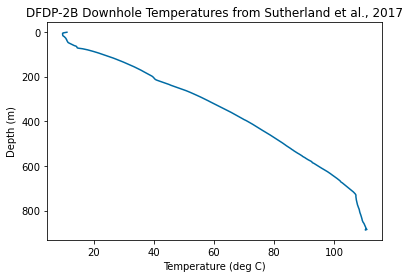

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(temp_data[5], temp_data[0])
ax.set_xlabel("Temperature (deg C)")
ax.set_ylabel("Depth (m)")
ax.set_title("DFDP-2B Downhole Temperatures from Sutherland et al., 2017")
ax.invert_yaxis()  # Invert the y-axis so increasing depth is down
plt.show()

## Array maths: calculating temperature gradient

Sutherland et al. calculated temperature gradients in degrees per km.  This is simply division, and we can do this really
easily with NumPy using the simple formula:
\begin{equation}
    T\ gradient = \frac{change\ in\ T}{change\ in\ depth}
\end{equation}

So, we need the change in temperature and change in depth at every step. We can do this by subtracting a 1-sample
shifted version of our column of interest from the column, e.g.

In [25]:
temperature_change = temp_data[5][1:] - temp_data[5][0:-1]

This looks a bit funky, but all that we have done is sliced our array so that we get the fifth column (the temperatures)
(using the `[5]` index) and taken the elements of that column between the zeroth to n-1-th indexes away from
that data from the same column, but from the 1st to the n-th index. 

We will do the same for the depth:

In [26]:
depth_change =  temp_data[0][1:] - temp_data[0][0:-1]

Lets plot our change in temperature to make sure we have something sensible.  We need to plot against depth, but our change in temperature
is an average over a depth range. We will plot against the mid-point of the depths that the change in temperature is calculated over, lets
make a new array that is that mid-point depth:

In [27]:
mid_point_depth = temp_data[0][0:-1] + depth_change / 2

All that we have done is add half the change in depth to the depth. We have to ignore the final depth sample because
we don't have a gradient that corresponds to this: there are no data beyond the end of the borehole, alas.

Now we can plot again:

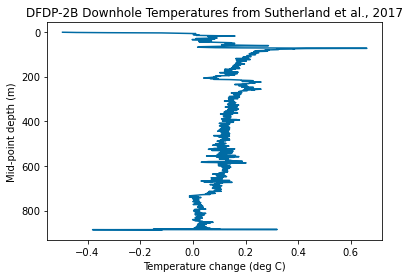

In [28]:
fig, ax = plt.subplots()
ax.plot(temperature_change, mid_point_depth)
ax.set_xlabel("Temperature change (deg C)")
ax.set_ylabel("Mid-point depth (m)")
ax.set_title("DFDP-2B Downhole Temperatures from Sutherland et al., 2017")
ax.invert_yaxis()  # Invert the y-axis so increasing depth is down
plt.show()

Now we have the change in temperature and the change in depth we can calculate the temperature gradient at each point as a simple
division.

To get the units into degrees per km we will divide our change in depth by 1000 to convert to km first.

In [29]:
depth_change /= 1000
temperature_gradient = temperature_change / depth_change

Again, lets plot the result at the mid-points:

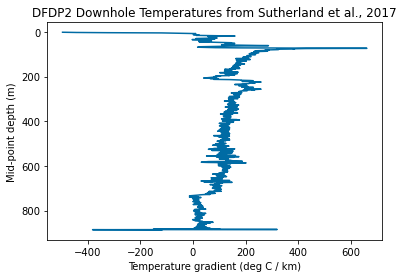

In [30]:
fig, ax = plt.subplots()
ax.plot(temperature_gradient, mid_point_depth)
ax.set_xlabel("Temperature gradient (deg C / km)")
ax.set_ylabel("Mid-point depth (m)")
ax.set_title("DFDP2 Downhole Temperatures from Sutherland et al., 2017")
ax.invert_yaxis()  # Invert the y-axis so increasing depth is down
plt.show()

A brief inspection shows that the last two plots look very similar, this is because the depth sampling is 1m.

**But wait!**  This isn't a true depth profile, this is just drilled depth...  We didn't drill a straight hole
(not deliberately, but these things happen when you are a few hundred meters down in highly-foliated schist...).

Let's have a look at what the hole looks like:

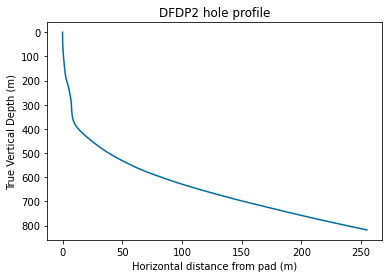

In [31]:
horizontal_distance = np.sqrt(temp_data[2] ** 2 + temp_data[3] ** 2)
fig, ax = plt.subplots()
ax.plot(horizontal_distance, temp_data[4])
ax.set_xlabel("Horizontal distance from pad (m)")
ax.set_ylabel("True Vertical Depth (m)")
ax.set_title("DFDP2 hole profile")
ax.invert_yaxis()  # Invert the y-axis so increasing depth is down
plt.show()

# Exercise:

Plot the temperature gradient against true vertical depth.  You will need to recalculate the depth changes and the temperature gradient to do this.

Do your plots look like the plot in the [Sutherland et al. paper](https://www.nature.com/articles/nature22355)?

In [32]:
# Your answer here

## Saving your data

So you have dome some cool things to your data, and you want to save your work.  You should always save your
notebook or scripts, and they should be your *sacred* way of doing your analysis.  But it is also
good to actually write out the data that you have processed.  With NumPy there are a few ways that you
can do that.  One of the simplest ways is using the 
[savetxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html) function:

In [33]:
np.savetxt("data/temperature_gradient.txt", temperature_gradient)

Lets check what is in that file by printing the first five lines:

In [34]:
with open("data/temperature_gradient.txt", "r") as f:
    for i in range(5):
        print(f.readline().rstrip())

nan
-4.949999999999992042e+02
-4.429999999999996021e+02
-3.230000000000003979e+02
-1.189999999999997726e+02


Looks correct.  Note that the `.rstrip` method on a string strips trailing white-space characters, in
this case it removes a new-line (`\n`) character.

## Summary

NumPy is at the heart of most scientific Python, but it can be unintuitive when thinking about many Earth science datasets. Having to remember which column and row things should be in can be a little frustrating. This is one of the things that Pandas can help us with and we will showcase this by using Pandas in the [next notebook](ESCI451_Module_2B.ipynb).